Overian Cancer Prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif

# Load the dataset
file_path = 'Supplementary data 1.xlsx'  # Replace with your local file path
data = pd.ExcelFile(file_path)
raw_data = data.parse('All Raw Data')

# Data cleaning
cleaned_data = raw_data.applymap(lambda x: str(x).strip() if isinstance(x, str) else x)
cleaned_data = cleaned_data.apply(pd.to_numeric, errors='coerce')

# Verify the data structure
print(cleaned_data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 51 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SUBJECT_ID  349 non-null    int64  
 1   AFP         325 non-null    float64
 2   AG          348 non-null    float64
 3   Age         349 non-null    int64  
 4   ALB         339 non-null    float64
 5   ALP         339 non-null    float64
 6   ALT         339 non-null    float64
 7   AST         339 non-null    float64
 8   BASO#       349 non-null    float64
 9   BASO%       349 non-null    float64
 10  BUN         349 non-null    float64
 11  Ca          349 non-null    float64
 12  CA125       330 non-null    float64
 13  CA19-9      315 non-null    float64
 14  CA72-4      109 non-null    float64
 15  CEA         327 non-null    float64
 16  CL          349 non-null    float64
 17  CO2CP       348 non-null    float64
 18  CREA        349 non-null    float64
 19  TYPE        349 non-null    i

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20208\4034247224.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  cleaned_data = raw_data.applymap(lambda x: str(x).strip() if isinstance(x, str) else x)


In [3]:
# Check unique values in 'TYPE'
print("Unique values in TYPE column:", cleaned_data['TYPE'].unique())

# Value counts in the target variable
print("Value counts:\n", cleaned_data['TYPE'].value_counts())


Unique values in TYPE column: [0 1]
Value counts:
 TYPE
1    178
0    171
Name: count, dtype: int64


In [5]:
# Impute missing values with the median
imputer = SimpleImputer(strategy='mean')
cleaned_data_imputed = pd.DataFrame(imputer.fit_transform(cleaned_data), columns=cleaned_data.columns)


In [6]:
# Separate features and target
X = cleaned_data_imputed.drop(['TYPE', 'SUBJECT_ID'], axis=1)
y = cleaned_data_imputed['TYPE']

# Select top 10 features based on ANOVA F-test
selector = SelectKBest(score_func=f_classif, k=10)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
print("Selected features:", selected_features)


Selected features: Index(['Age', 'ALB', 'CA125', 'HE4', 'LYM#', 'LYM%', 'Menopause', 'NEU', 'PCT',
       'PLT'],
      dtype='object')


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)


In [8]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


In [ ]:
# Define the model
model = RandomForestClassifier(random_state=42)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 500],          # Number of trees
    'max_depth': [None, 10, 20, 30],              # Maximum depth of trees
    'min_samples_split': [2, 5, 10],              # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],                # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2', None],       # Number of features to consider at each split
    'bootstrap': [True, False],                   # Whether bootstrap samples are used
}

# Use RandomizedSearchCV for efficiency
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=50,       # Number of combinations to try
    cv=5,            # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1        # Use all processors
)


In [10]:
# Fit the RandomizedSearchCV
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_
print("Best parameters:", best_params)

# Train the model with the best parameters
best_model = random_search.best_estimator_


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}


Optimized Model Accuracy: 0.8857142857142857
Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.83      0.88        35
         1.0       0.85      0.94      0.89        35

    accuracy                           0.89        70
   macro avg       0.89      0.89      0.89        70
weighted avg       0.89      0.89      0.89        70



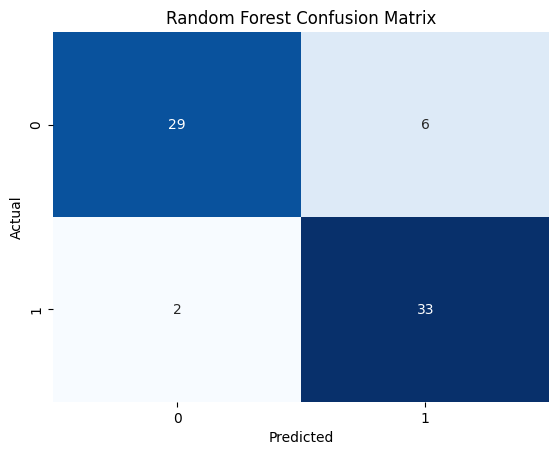

In [11]:
# Predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the performance
print("Optimized Model Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
